In [1]:
from __future__ import division 
import matplotlib.pyplot as plt
%matplotlib inline
import emotion_analysis
emo = emotion_analysis.EmotionAnalysis()

In [2]:
inp, lab = emo.prepare_dataset('data')

Read audio file 'data\negative_38.wav', count: 100
Read audio file 'data\neutral_221.wav', count: 200
Read audio file 'data\neutral_490.wav', count: 300
Read audio file 'data\positive_303.wav', count: 400
Read audio file 'data\positive_55.wav', count: 500


In [3]:
from random import shuffle
import numpy as np

dataset = zip(inp, lab)
shuffle(dataset)
inp, lab = zip(*dataset)
max_value = max([max(i) for i in inp])
min_value = min([min(i) for i in inp])
#normalised_inp = np.asarray(inp)/max_value
inp = (np.asarray(inp)-min_value)/(max_value-min_value)

In [4]:
from pybrain.structure.modules import LSTMLayer, SoftmaxLayer, TanhLayer
from pybrain.supervised import RPropMinusTrainer, BackpropTrainer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SequenceClassificationDataSet, ClassificationDataSet

In [42]:
lab_to_int = {'neutral':0, 'positive':1, 'negative':2}
int_to_lab = {0:'neutral', 1:'positive', 2:'negative'}
alldata = ClassificationDataSet(len(inp[0]), 1, nb_classes = 3)
#for i in range(int(len(inp)*3/4)):
for i in range(int(len(inp))):
   alldata.addSample(inp[i],lab_to_int[lab[i]])

In [43]:
testdata, traindata = alldata.splitWithProportion(0.25)

In [44]:
len(testdata['input'])

128

In [45]:
testdata._convertToOneOfMany()
traindata._convertToOneOfMany()

In [46]:
rnn = buildNetwork(traindata.indim,158, 105, traindata.outdim, hiddenclass = TanhLayer, outclass = SoftmaxLayer)
trainer = RPropMinusTrainer(rnn, dataset = traindata, verbose = True)
error = []
counter = 0

In [47]:
for i in range(1000):
    print "Epoch: "+str(counter)
    error.append(trainer.train())
    print ""
    counter += 1

Epoch: 0
epoch      0  total error      0.21032   avg weight        0.9997

Epoch: 1
epoch      1  total error      0.20865   avg weight        1.0043

Epoch: 2
epoch      2  total error      0.22165   avg weight        1.0091

Epoch: 3
epoch      3  total error      0.23432   avg weight        1.0126

Epoch: 4
epoch      4  total error      0.20858   avg weight        1.0165

Epoch: 5
epoch      5  total error      0.22165   avg weight        1.0204

Epoch: 6
epoch      6  total error      0.20575   avg weight        1.0214

Epoch: 7
epoch      7  total error      0.23399   avg weight        1.0226

Epoch: 8
epoch      8  total error      0.20736   avg weight        1.0228

Epoch: 9
epoch      9  total error         0.19   avg weight        1.0228

Epoch: 10
epoch     10  total error      0.23275   avg weight        1.0234

Epoch: 11
epoch     11  total error      0.19829   avg weight        1.0235

Epoch: 12
epoch     12  total error      0.21199   avg weight        1.0238

Epoch: 13

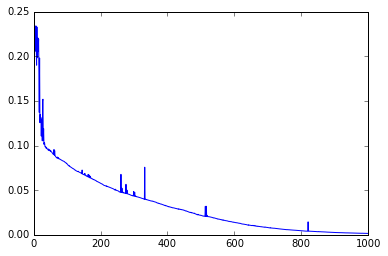

In [48]:
x=[i for i in range(len(error))]
plt.plot(x, error)
plt.show()

In [49]:
y_pred_train = [rnn.activate(point).argmax() for point in traindata['input']]
y_actual_train =[int(output[0]) for output in traindata['class']]

In [50]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_actual_train, y_pred_train, labels=[0,1,2])
print "Precision = "+str(precision)+"\nRecall = "+str(recall)+"\nF1 Score = "+str(f1_score)

Precision = [ 0.99224806  1.          0.99107143]
Recall = [ 0.99224806  1.          0.99107143]
F1 Score = [ 0.99224806  1.          0.99107143]


In [66]:
y_pred_test = [rnn.activate(point).argmax() for point in testdata['input']]
y_actual_test = [int(output[0]) for output in testdata['class']]

In [67]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_actual_test, y_pred_test, labels=[0,1,2])
print "Precision = "+str(precision)+"\nRecall = "+str(recall)+"\nF1 Score = "+str(f1_score)

Precision = [ 0.43589744  0.38888889  0.34285714]
Recall = [ 0.37777778  0.51219512  0.28571429]
F1 Score = [ 0.4047619   0.44210526  0.31168831]


In [64]:
y_pred_test = [rnn.activate(point).argmax() for point in inp[int(3/4*len(inp)):]]
y_actual_test = [lab_to_int[output] for output in lab[int(3/4*len(inp)):]]

In [65]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_actual_test, y_pred_test, labels=[0,1,2])
print "Precision = "+str(precision)+"\nRecall = "+str(recall)+"\nF1 Score = "+str(f1_score)

Precision = [ 0.86666667  0.82258065  0.86486486]
Recall = [ 0.8125      0.91071429  0.7804878 ]
F1 Score = [ 0.83870968  0.86440678  0.82051282]


Enter the name of the call file name.
> negative_15.wav


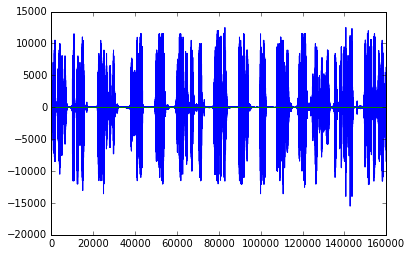

In [82]:
import feature_extractor
import scipy.io.wavfile as wav
import math

extractor = feature_extractor.FeatureExtractor()

file_name = raw_input("Enter the name of the call file name.\n> ")
rate_sig, sig = wav.read(file_name)

plt.plot(sig)
plt.plot((0,len(sig)),(0,0),'g')
plt.show()

complete_call_result = int_to_lab[rnn.activate(extractor.extract_features(audio_signal = (rate_sig, sig))).argmax()]
first_half_result = int_to_lab[rnn.activate(extractor.extract_features(audio_signal = (rate_sig, sig[:int(len(sig)/2)]))).argmax()]
second_half_result = int_to_lab[rnn.activate(extractor.extract_features(audio_signal = (rate_sig, sig[int(len(sig)/2):]))).argmax()]
segment_result = []
for i in range(int(math.ceil(len(sig)/(rate_sig*20)))):
    segment_result.append(int_to_lab[rnn.activate(extractor.extract_features(audio_signal = (rate_sig, sig[i*rate_sig*20:i*rate_sig*20+rate_sig*20]))).argmax()])

Overall call result: positive
Trainsition: positive --> positive


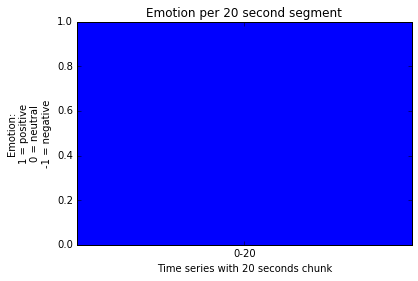

In [83]:
import numpy as np
from __future__ import division
print "Overall call result: "+complete_call_result
print "Trainsition: "+first_half_result+" --> "+second_half_result
map_dict = {'negative':-1, 'neutral':0, 'positive':1}
mapped_segment_result = [map_dict[result] for result in segment_result]
index = [i for i in range(len(mapped_segment_result))]
index = np.asarray(index)
bar_width = 1
plt.plot((0,index[-1]+1),((0,0)), 'r')
plt.bar(index, mapped_segment_result, bar_width)
plt.xticks(index + bar_width/2 , (str(i*20)+'-'+str((i+1)*20) for i in index))
plt.xlabel('Time series with 20 seconds chunk')
#plt.axes([0, 100, -2, 2])
plt.ylabel('Emotion:\n1 = positive\n0 = neutral\n-1 = negative')
plt.title('Emotion per 20 second segment')
plt.show()

In [57]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, ['neutral','positive','negative'], rotation=45)
    plt.yticks(tick_marks, ['neutral','positive','negative'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[128   0   1]
 [  0 144   0]
 [  1   0 111]]


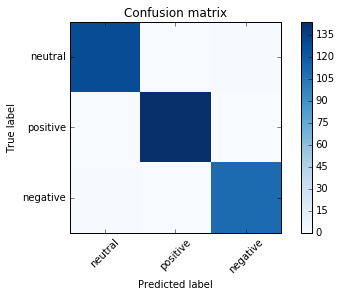

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual_train, y_pred_train, labels=[0,1,2])
print cm
plot_confusion_matrix(cm)

[[26  5  1]
 [ 1 51  4]
 [ 3  6 32]]


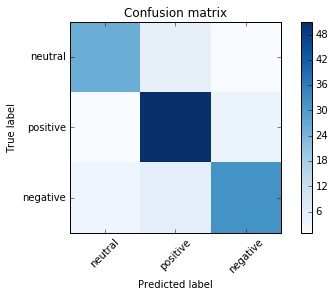

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual_test, y_pred_test, labels=[0,1,2])
print cm
plot_confusion_matrix(cm)

In [68]:
len([1 for i in range(len(y_pred_test)) if y_pred_test[i]==y_actual_test[i]])/float(len(y_pred_test))

0.390625

In [61]:
lab[1] 

'positive'